# Calculation of detectable Gamma ray burst (GRB) event rate associated with Binary Neutron Star (BNS) mergers.

* This is without considering a particular detectors' sensitivity, but rather a general calculation of the rate of detectable GRBs based of viewing angle and luminosity distance. I have considered the inclination angle gravitational waves same as the viewing angle wrt GRB jet axis.

* It involves constructing Pdet (detection probability) function based off luminosity function.

* For BNS source redshift and mass distribution, refer [here](https://ler.readthedocs.io/en/latest/GW_events.html).

* For lens and image properties, refer [here](https://ler.readthedocs.io/en/latest/Lensed_events.html).

* Both SWIFT and FERMI detectors are considered.

* All analysis will be limited to redshift $z\in [0,5]$.

## Result summary


### Condition 1 (EM->GW)

Steps:
1. Sample GRB detectable events from BNS merger events.
2. Calculate rate
3. Check, out of these GRB detectable events, how many are detectable in GWs.

I will consider sub-threshold events as detectable (snr>6).

<!-- | Event | Unlensed | Lensed | ratio(Unlensed/Lensed) |
| --- | --- | --- | --- |
| GRB | 2127.81 | 1.51 | 1:1409.14 |
| GW | 0.297 | 1.8e-4 | 1:1650.00 |
| ratio(GRB/GW) | 7164.34 | 8389 | - | -->
| Event | Unlensed | Lensed | ratio(Unlensed/Lensed) |
| --- | --- | --- | --- |
| GRB | 9459.41 | 7.446 | 1:1270 |
| GW | 1.135 | 8.94e-4 | 1:1269.57 |
| ratio(GW/GRB) | 1:8334 | 1:8329 | - |

### Condition 2 (GW->EM)

Steps:
1. Sample GW detectable events from BNS merger events.
2. Calculate rate
3. Check, out of these GW detectable events, how many are detectable in GRBs.

I will consider super-threshold events only (snr>8).

<!-- | Event | Unlensed | Lensed | ratio(Unlensed/Lensed) |
| --- | --- | --- | --- |
| GW | 3.0 | 6.63e-3 | 1:452.83 |
| GRB | 0.123 | 1.54-4 | 1:12520.33 |
| ratio(GW/GRB) | 24.39 | 4.31 | - | -->
| Event | Unlensed | Lensed | ratio(Unlensed/Lensed) |
| --- | --- | --- | --- |
| GW | 13.18 | 2.96e-2 | 1:454.48 |
| GRB | 0.632 | 4.56e-4 | 1:1404.4 |
| ratio(GRB/GW) | 1:20 | 1:64 | - |



## Equations (GRB)

* Ref: [Howell et. al. (2019)](https://arxiv.org/pdf/1811.09168)

* The luminosity function of GRBs is given by:

$$L(\theta_{V})=L_{c}\text{exp}(-\frac{\theta^{2}}{2\theta_{c}^{2}})$$

* Here, $L(\theta_{V})$ is the luminosity at viewing angle $\theta_{V}$, $L_{c}$ is the luminosity at the jet axis, $\theta$ is the viewing angle, and $\theta_{c}$ is the core angle of the jet.

* The paper gives: $\theta_{c} = 5$ degree.

* I will infer the probability of detection from the above equations.

$$P_{det}(\theta,D_L) = \left\{ 
  \begin{array}{ c l }
    1 & \text{if } \theta \le 5 \text{ deg and } D_L \le 46652 \text{ Mpc } (z\sim 5) \\
    1 & \text{if } \frac{\text{a}}{4\pi D_L^2} \text{exp}(-\frac{\theta^{2}}{2\times 21.2^2}) \ge 1 \\
    0 & \text{otherwise}
  \end{array}
\right.$$

* Coefficients a is solved by considering conditions 2 below.,
  1. If angle <= 5 deg, distance <= distance_cut, then $P_{det}$ = 1.
  2. pdet=1, If angle=21.2 deg (at distance=40Mpc). This is by considering the GRB from GW170817 would have been difficult to detect if viewing angle>21.2 deg (at distance=40Mpc) or distance>40 Mpc (at angle=21.2 deg).

In [1]:
from ler.rates import LeR
import numpy as np
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

## Probability of detection of GRBs

### Finding the coefficients

In [2]:
import numpy as np
from scipy.optimize import fsolve

# to find coefficient a
# consider: pdet = 1, If angle = 21.2 deg (at distance=40). 
def equation(a):
    angle = 21.2
    distance = 40
    return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

a_guess = 10000

# Solve the equation
a_solution = fsolve(equation, a_guess)

print(f"a = {a_solution[0]}")

a = 161107621.34601912


### Function to calculate the probability of detection

In [3]:
# Find distance_cut, z=5
# convert redshift to luminoisty distance
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
z = 5
d_L = cosmo.luminosity_distance(z)
print(f"d_L = {d_L}")

d_L = 46652.22297277721 Mpc


In [4]:
# interpolation to convert luminoisty distance to redshift
from scipy import interpolate
z = np.geomspace(0.0001, 10, 1000)
d_L = cosmo.luminosity_distance(z)
dl_to_z = interpolate.interp1d(d_L, z)

In [5]:
# distance_cut: z ~ 5
def pdet_grb(angle, distance, distance_cut=46652, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=1.):
    """
    Function to calculate the probability of detection for a given angle and distance for GRB. Coefficient involved is based on 2 the following conditions,

    Note: GRB jet, core angle <= 5 deg
    1. If angle <= 5 deg, distance <= distance_cut, then pdet(bool) = 1
    2. pdet=1, If angle=21.2 deg (at distance=40Mpc). This is by considering the GRB from GW170817 would have been difficult to detect if viewing angle<21.2 deg (at distance=40Mpc) or distance<40 Mpc (at angle=21.2 deg).

    Parameters
    ----------
    angle : numpy.ndarray
        Angle between the GRB jet and viewing angle in (rad)
    distance : numpy.ndarray
        Distance between the GRB source and the satellite in (Mpc)
    distance_cut : float
        Core angular size of the GRB jet in (rad)
        default is 25422.742 Mpc
    duty_cycle : float
        Duty cycle of detector(s)
        default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
    bool : bool
        if True, return absolute value of pdet
        if False, return the pdet value as boolean (with duty cycle applied)
    """

    # coefficients, obtained with scipy.optimize fsolve by considering the condition 2,3 listed in docstring

    a = 161107621.34601912
    jet_angle_cut = 5

    # convert angle to degree
    angle = np.degrees(angle)

    # make sure that the input data is a numpy array
    angle, distance = np.array([angle]).reshape(-1), np.array([distance]).reshape(-1)

    # angle should be less than 90 or equal to 90
    if len(angle[angle > 90]) > 0:
        angle[angle > 90] = angle[angle > 90]%90

    if bool:
        # calculate the probability of detection, absolute value
        pdet = abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))

        # find idx of angle <= jet_angle_cut and distance <= distance_cut
        idx = (angle <= jet_angle_cut) & (distance <= distance_cut)
        # apply the condition, condition 1 from docstring
        pdet[idx] = 1

        if mask_duty_cycle:
            # apply the duty cycle
            # sample random numbers from 0 to 1 and check if it is less than the duty cycle
            num_ = np.random.rand(len(angle))
            mask_duty_cycle = num_ > duty_cycle
            pdet[mask_duty_cycle] = 0

        # return the pdet as boolean
        return (pdet>=pdet_cut).astype(int)
    else:
        # return the probability of detection (absolute value)
        return abs((1 / (1 + (angle / 5)**c))* (40/distance)**2 * a/(4*np.pi))

### test

In [6]:
angle = np.array([1, 1, 20, 90])
angle = np.radians(angle)
distance = np.array([46652, 46653, 40, 40])
print(pdet_grb(angle, distance, mask_duty_cycle=False, bool=True))

[1 0 1 0]


### Plot detection and non-detection

In [7]:
# generate random data
angle = np.random.uniform(0, 30, 5000)
log10_distance = np.random.uniform(0, 5, 5000)
distance = 10**log10_distance
redshift = dl_to_z(distance)

pdet = pdet_grb(np.radians(angle), distance, mask_duty_cycle=False, bool=True)

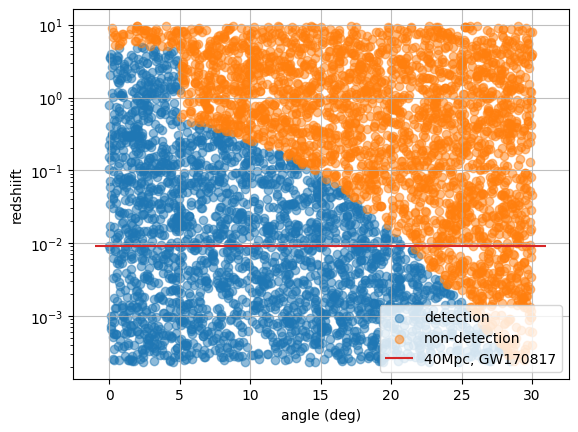

In [8]:
# blue: detection, red: non-detection
plt.scatter(angle[pdet==1], redshift[pdet==1], c='C0', label="detection", alpha=0.5)
plt.scatter(angle[pdet==0], redshift[pdet==0], c='C1', label="non-detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
plt.hlines(y=dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

plt.xlabel("angle (deg)")
plt.ylabel("redshiift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

### Pdet condition checks

In [9]:
print("condition 1, pdet(angle=core_angle,distance=distance_cut): ", pdet_grb(angle=np.radians(5), distance=46652, mask_duty_cycle=False, bool=True))

print("condition 2")
print("  i) Detectable, pdet(angle=21.2deg,distance=40Mpc): ", pdet_grb(angle=np.radians(21.2), distance=40, mask_duty_cycle=False, bool=True))
print("  ii) Not-Detectable, pdet(angle=21.3deg,distance=40Mpc): ", pdet_grb(angle=np.radians(21.3), distance=40, mask_duty_cycle=False, bool=True))
print("  iii) Not-Detectable, pdet(angle=21.2deg,distance=50Mpc): ", pdet_grb(angle=np.radians(21.2), distance=50, mask_duty_cycle=False, bool=True))

condition 1, pdet(angle=core_angle,distance=distance_cut):  [1]
condition 2
  i) Detectable, pdet(angle=21.2deg,distance=40Mpc):  [1]
  ii) Not-Detectable, pdet(angle=21.3deg,distance=40Mpc):  [0]
  iii) Not-Detectable, pdet(angle=21.2deg,distance=50Mpc):  [0]


* let's write out the function so that it can be used in with LeR
  
* consider 50% duty cycle, i.e. it assume 50% of the sky is observable at any given time with SWIFT and FERMI detectors.

In [10]:
from gwsnr.utils import save_json_dict

# let's write out the function so that it can be used in with LeR
def pdet_calculator(gw_param_dict, duty_cycle=0.5, mask_duty_cycle=True, bool=True, output_jsonfile=False):
    """
    Function to calculate the probability of detection for a given angle and distance for GRB. This is based on the following condition

    Note: GRB jet, core angle <= 5 deg
    1. If angle <= 5 deg, distance <= distance_cut, then pdet(bool) = 1
    2. pdet=1, If angle=21.2 deg (at distance=40Mpc). This is by considering the GRB from GW170817 would have been difficult to detect if viewing angle<21.2 deg (at distance=40Mpc) or distance<40 Mpc (at angle=21.2 deg).

    Parameters
    ----------
    gw_param_dict : dict
        dictionary containing the parameters for the GW event
    """

    # get the angle and distance from the dictionary
    angle = gw_param_dict['theta_jn']
    if 'luminosity_distance' in gw_param_dict:
        distance = gw_param_dict['luminosity_distance']
    elif 'effective_luminosity_distance' in gw_param_dict:
        distance = gw_param_dict['effective_luminosity_distance']

    # calculate the probability of detection
    pdet = pdet_grb(angle, distance, duty_cycle=duty_cycle, mask_duty_cycle=mask_duty_cycle, bool=bool)
    pdet_net_dict = dict(pdet_net=pdet)

    # Save as JSON file, if output_jsonfile is provided
    if output_jsonfile:
        output_filename = (
            output_jsonfile if isinstance(output_jsonfile, str) else "pdet.json"
        )
        save_json_dict(pdet_net_dict, output_filename)

    # return the pdet
    return pdet_net_dict

In [11]:
# test
gw_param_dict = {'theta_jn': np.radians(np.array([1, 21.2, 90])), 'luminosity_distance': np.array([2500, 40, 40])}
print(pdet_calculator(gw_param_dict, mask_duty_cycle=False, bool=True))

{'pdet_net': array([1, 1, 0])}


## Rate calculation of GRB with LeR

All the necessary functions and parameters are defined below.

**Source related:**
* source frame mass: m1 and m2 sample from [double Gaussian](https://ler.readthedocs.io/en/latest/GW_events.html#BNS-mass-distribution:-Bimodal-Gaussian-Model) model lim[1,2.3]Mo
* Geocent time period: uniform prior, 1 year GPS: {'min_': 1238166018, 'max_': 1269702018}
* Redshift: 0 to 5, uniform, 
  * this follows [merger rate density distribution](https://ler.readthedocs.io/en/latest/GW_events.html#Merger-Rate-Density-Formula)
* ra:  sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* dec:  sampler_cosine [-np.pi/2, np.pi/2]
* phase : sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* psi: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}
* theta_jn:   sampler_sine  [0, np.pi]

**Lens related**
* Optical depth: SIE , 
  * so zs for lensed are rejection sampled with optical depth. 
* Lens redshifts: SDSS catalogue (0 to zs), the function of zs Reenske et al. 2021 ( eqnC13). [`ler` function](https://github.com/hemantaph/ler/blob/bce3330638a13ee0883d19633abb17b98791c901/ler/lens_galaxy_population/jit_functions.py#L218)
* Velocity dispersion: gengamma, Haris et al 2018, a=2.32 / 2.67, c=2.67, vd_min=0., vd_max=600.(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gengamma.html) use in Haris et al upto zs~1.5 (with a=2.32 / 2.67, c=2.67)
* Axis ratio: Raleigh (with Velocity dispersion dependence) {'q_min': 0.2, 'q_max': 1.0}
* axis_rotation_angle : uniform {'phi_min': 0.0, 'phi_max': 6.283185307179586}
* shear: normal {'scale': 0.05}
* mass_density_spectral_index: normal {'mean': 2.0, 'std': 0.2}

**Image related:**
* Strong lensing condition: num_images>=2
* Lens equation solver: EPL+Shear, `lenstronomy`
* Source position: sample within caustic,  Ewoud et. al. 2022

In [65]:
# from ler.rates import LeR
# import numpy as np
# import matplotlib.pyplot as plt
ler = LeR(
    npool=6,
    verbose=False,
    z_max=5,
    pdet_finder=pdet_calculator, 
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

### Unlensed events

In [66]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=200000,
    batch_size=200000,
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_grb.json",
    meta_data_file="meta_unlensed_grb.json",
)

collected number of detectable events =  200000
storing detectable unlensed params in ./ler_data/n_unlensed_params_detectable_grb.json

 trmming final result to size=200000


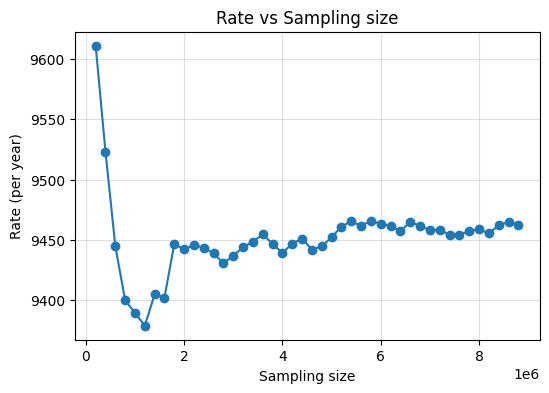

In [67]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_grb.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [68]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 6e6)[0]
# take average 
rate_unlensed = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', rate_unlensed)

Unlensed GRB Rate (per year) = 9459.414630137671


### Plots

In [69]:
unlensed_param_detectable = get_param_from_json("ler_data/n_unlensed_params_detectable_grb.json")
zs = unlensed_param_detectable['zs']
viewing_angle = unlensed_param_detectable['theta_jn']
# radian to degree
viewing_angle = np.degrees(viewing_angle)
# if angle > 90, then angle = 180 - angle
viewing_angle[viewing_angle > 90] = viewing_angle[viewing_angle > 90]-90

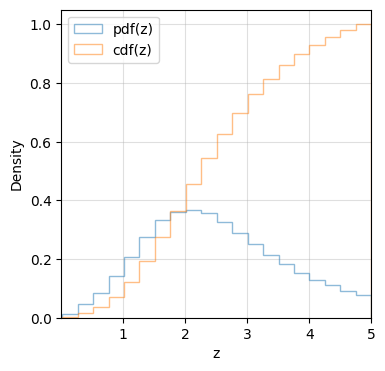

In [70]:
plt.figure(figsize=(4,4))
plt.hist(zs, bins=20, alpha=0.5, label='pdf(z)', density=True, histtype='step')
# cdf
plt.hist(zs, bins=20, alpha=0.5, label='cdf(z)', density=True, histtype='step', cumulative=True)
plt.xlabel('z')
plt.ylabel('Density')
plt.xlim(0.0001, 5)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

* for comparison refer to Fig.4 [Perley et. al.](https://arxiv.org/pdf/1504.02482)

* my rate is lower than the above paper, in the local universe.

* local merger rate density considered in `ler` for the BNS is 150.5 Gpc^-3 yr^-1 

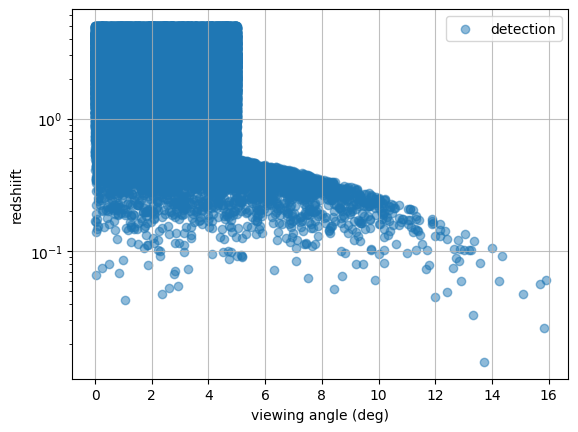

In [71]:
# blue: detection, red: non-detection
plt.scatter(viewing_angle, zs, c='C0', label="detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
# plt.hlines(y=dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

plt.xlabel("viewing angle (deg)")
plt.ylabel("redshiift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

### Checking how many of these events are detectable in GWs

In [72]:
ler = LeR(
    verbose=False,
    z_max=5,
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [73]:
snr_unlensed = ler.snr(gw_param_dict=unlensed_param_detectable)['optimal_snr_net']

In [74]:
# super-threshold only
# number of detectable events in terms of GW snr out of already detected events in term of GRB pdet
print(f"Number of unlensed detectable events in terms of GW snr is {np.sum(snr_unlensed>8)} \nout of {len(snr_unlensed)} events that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable unlensed GRBs is {9459.414630137671}, \nthen the rate of detectable GWs is {9459.414630137671*np.sum(snr_unlensed>8)/len(snr_unlensed)}\n")

print(f"ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = {len(snr_unlensed)/np.sum(snr_unlensed>8)}")

Number of unlensed detectable events in terms of GW snr is 9 
out of 200000 events that are already detected in terms of GRB pdet

if the rate of detectable unlensed GRBs is 9459.414630137671, 
then the rate of detectable GWs is 0.42567365835619525

ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = 22222.222222222223


In [76]:
# sub-threshold considered
# number of detectable events in terms of GW snr out of already detected events in term of GRB pdet
print(f"Number of unlensed detectable events in terms of GW snr is {np.sum(snr_unlensed>6)} \nout of {len(snr_unlensed)} events that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable unlensed GRBs is {9459.414630137671}, \nthen the rate of detectable GWs is {9459.414630137671*np.sum(snr_unlensed>6)/len(snr_unlensed)}\n")

print(f"ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = {len(snr_unlensed)/np.sum(snr_unlensed>6)}")

Number of unlensed detectable events in terms of GW snr is 24 
out of 200000 events that are already detected in terms of GRB pdet

if the rate of detectable unlensed GRBs is 9459.414630137671, 
then the rate of detectable GWs is 1.1351297556165205

ratio (unlensed detectable GRBs)/(unlensed detectable GWs) = 8333.333333333334


### Lensed events

In [82]:
ler = LeR(
    npool=6,
    verbose=False,
    z_max=5,
    pdet_finder=pdet_calculator, 
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [83]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=50000,
    batch_size=200000,
    # snr_threshold=[8.0,8.0],
    # num_img=[1,1],
    resume=True,
    trim_to_size=True,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_grb.json",
    meta_data_file="meta_lensed_grb.json",
)

collected number of detectable events =  51818.0
storing detectable lensed params in ./ler_data/n_lensed_params_detectable_grb.json

 trmming final result to size=50000


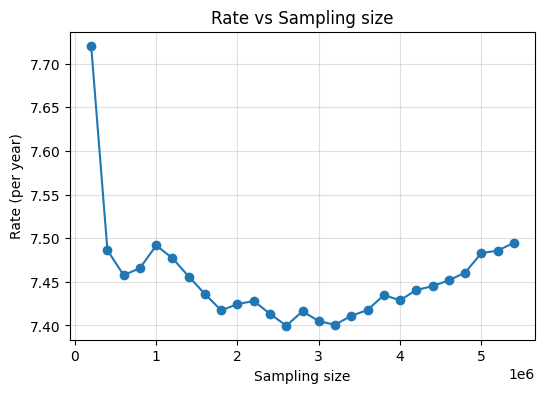

In [84]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [85]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 3e6)[0]
# take average 
rate_lensed = np.mean(meta_data['total_rate'][idx])
print('Lensed GRB Rate (per year) =', rate_lensed)

Lensed GRB Rate (per year) = 7.446211556304424


### Plots

In [86]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_grb.json")
zs = lensed_param_detectable['zs']
viewing_angle = lensed_param_detectable['theta_jn']
# radian to degree
viewing_angle = np.degrees(viewing_angle)
# if angle > 90, then angle = 180 - angle
viewing_angle[viewing_angle > 90] = viewing_angle[viewing_angle > 90]-90

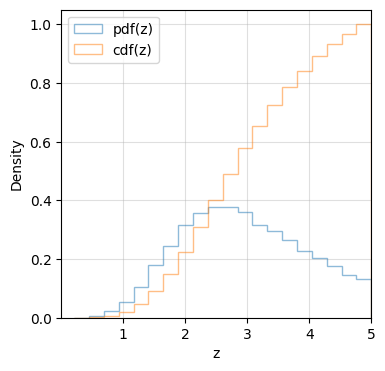

In [88]:
plt.figure(figsize=(4,4))
plt.hist(zs, bins=20, alpha=0.5, label='pdf(z)', density=True, histtype='step')
# cdf
plt.hist(zs, bins=20, alpha=0.5, label='cdf(z)', density=True, histtype='step', cumulative=True)
plt.xlabel('z')
plt.ylabel('Density')
plt.xlim(0.0001, 5)
plt.legend()
plt.grid(alpha=0.4)
plt.show()

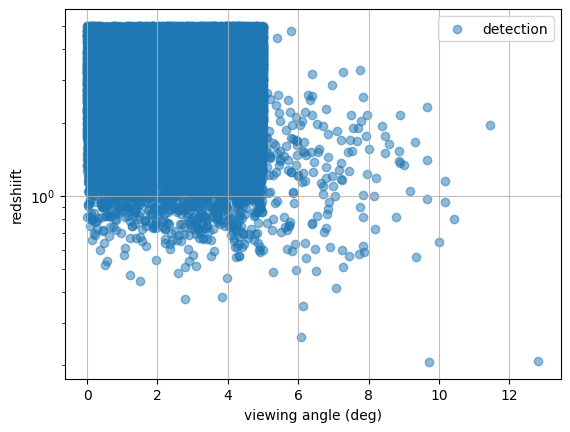

In [89]:
# blue: detection, red: non-detection
plt.scatter(viewing_angle, zs, c='C0', label="detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
# plt.hlines(y=dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')

plt.xlabel("viewing angle (deg)")
plt.ylabel("redshiift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

* at high redshift (z>1), detection of off-axis GRBs is still possible for the lensed case, but not for the unlensed case.

### Out of the detected GRB events, how many are detectable in GW.

* find out GW detector SNRs of the event which are detectable in GRBs.

* check how many of them cross the SNR threshold

In [90]:
# ler initialization with default snr calculator (gwsnr)
ler = LeR(
    verbose=False,
    z_max=5,
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [91]:
# get snr for the lensed events
snr_lensed, _ = ler.get_lensed_snrs(lensed_param_detectable, list_of_detectors=['L1','H1','V1'], snr_calculator=ler.snr)
snr_lensed = snr_lensed['optimal_snr_net']

In [92]:
# only super-threshold events
num_ =  np.sum(np.sum(snr_lensed>8, axis=1)>=2)
print(f"Number of lensed detectable events in terms of GW snr is {num_} out of {len(snr_lensed)} \nevents that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable lensed GRBs is {7.446211556304424}, \nthen the rate of detectable GWs is {7.446211556304424*num_/len(snr_lensed)}\n")

print(f"ratio (lensed detectable GRBs)/(lensed detectable GWs) = {len(snr_lensed)/num_}")

Number of lensed detectable events in terms of GW snr is 3 out of 50000 
events that are already detected in terms of GRB pdet

if the rate of detectable lensed GRBs is 7.446211556304424, 
then the rate of detectable GWs is 0.00044677269337826546

ratio (lensed detectable GRBs)/(lensed detectable GWs) = 16666.666666666668


In [93]:
# sub-threshold events considered
num_ =  np.sum(np.sum(snr_lensed>6, axis=1)>=2)
print(f"Number of lensed detectable events in terms of GW snr is {num_} out of {len(snr_lensed)} \nevents that are already detected in terms of GRB pdet\n")

print(f"if the rate of detectable lensed GRBs is {7.446211556304424}, \nthen the rate of detectable GWs is {7.446211556304424*num_/len(snr_lensed)}\n")

print(f"ratio (lensed detectable GRBs)/(lensed detectable GWs) = {len(snr_lensed)/num_}")

Number of lensed detectable events in terms of GW snr is 6 out of 50000 
events that are already detected in terms of GRB pdet

if the rate of detectable lensed GRBs is 7.446211556304424, 
then the rate of detectable GWs is 0.0008935453867565309

ratio (lensed detectable GRBs)/(lensed detectable GWs) = 8333.333333333334


## results

### Table for GRB and GW number of events

| Event | Unlensed | Lensed | ratio(Unlensed/Lensed) |
| --- | --- | --- | --- |
| GRB | 9459.41 | 7.446 | 1:1270 |
| GW | 1.135 | 8.94e-4 | 1269.57 |
| ratio(GW/GRB) | 1:8334 | 1:8329 | - |

In [97]:
1.135 / 8.94e-4

1269.5749440715883

In [ ]:
if the rate of detectable lensed GRBs is 7.446211556304424, 
then the rate of detectable GWs is 2.62401272772397

ratio (lensed detectable GRBs)/(lensed detectable GWs) = 2.837719298245614

## GW detection first

### Unlensed events

In [41]:
# from ler.rates import LeR
# from ler.utils import get_param_from_json

ler = LeR(
    verbose=False,
    z_max=5,
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [42]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=1000,
    batch_size=200000,
    snr_threshold=8.0,
    resume=True,
    trim_to_size=True,
    output_jsonfile="n_unlensed_params_detectable_gw.json",
    meta_data_file="meta_unlensed_gw.json",
)

collected number of detectable events =  0
collected number of detectable events =  2
total number of events =  200000
total unlensed rate (yr^-1): 4.131880725782083
collected number of detectable events =  10
total number of events =  400000
total unlensed rate (yr^-1): 10.329701814455209
collected number of detectable events =  17
total number of events =  600000
total unlensed rate (yr^-1): 11.706995389715903
collected number of detectable events =  23
total number of events =  800000
total unlensed rate (yr^-1): 11.87915708662349
collected number of detectable events =  33
total number of events =  1000000
total unlensed rate (yr^-1): 13.635206395080875
collected number of detectable events =  41
total number of events =  1200000
total unlensed rate (yr^-1): 14.11725914642212
collected number of detectable events =  52
total number of events =  1400000
total unlensed rate (yr^-1): 15.346985552904883
collected number of detectable events =  60
total number of events =  1600000
total

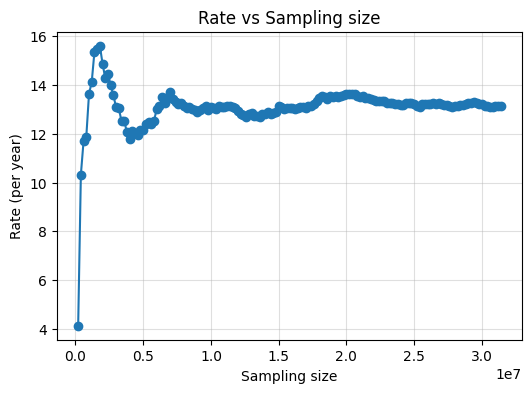

In [43]:
# rate
meta_data= get_param_from_json("ler_data/meta_unlensed_gw.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [44]:
# select only events after sampling size of
idx = np.where(meta_data['events_total'] > 2.5e7)[0]
# take average
rate_unlensed = np.mean(meta_data['total_rate'][idx])
print('Unlensed GW Rate (per year) =', rate_unlensed)

Unlensed GW Rate (per year) = 13.183887839677515


### How many detectable events are there in terms of GRB pdet out of already detected events in terms of GW snr?

In [45]:
unlensed_grb_pdet = pdet_calculator(unlensed_param_detectable)

In [56]:
# number of detectable events in terms of GRB pdet out of already detected events in term of GW snr
print(f"Number of unlensed detectable events in terms of GRB pdet is {np.sum(unlensed_grb_pdet['pdet_net']==1)} \nout of {len(unlensed_grb_pdet['pdet_net'])} events that are already detected in terms of GW snr\n")

print(f"if the rate of detectable unlensed GWs is {13.18}, \nthen the rate of detectable GRBs is {13.18*np.sum(unlensed_grb_pdet['pdet_net']==1)/len(unlensed_grb_pdet['pdet_net'])}\n")

print(f"ratio (unlensed detectable GWs)/(unlensed detectable GRBs) = {len(unlensed_grb_pdet['pdet_net'])/np.sum(unlensed_grb_pdet['pdet_net']==1)}")

Number of unlensed detectable events in terms of GRB pdet is 48 
out of 1000 events that are already detected in terms of GW snr

if the rate of detectable unlensed GWs is 13.18, 
then the rate of detectable GRBs is 0.63264

ratio (unlensed detectable GWs)/(unlensed detectable GRBs) = 20.833333333333332


### Lensed events

In [98]:
ler = LeR(
    verbose=False,
    z_max=5,
    event_type='BNS',
    mtot_max=51,
    ifos=['L1','H1','V1'],
)

In [99]:
# sub-threshold events considered
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=10000,
    batch_size=200000,
    snr_threshold=[6.0,6.0],
    num_img=[1,1],
    resume=True,
    output_jsonfile="n_lensed_params_detectable_gw.json",
    meta_data_file="meta_lensed_gw.json",
)

collected number of detectable events =  2588.0


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


collected number of events =  2604.0
total number of events =  24400000
total lensed rate (yr^-1): 0.08335298571741281


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


collected number of events =  2626.0
total number of events =  24600000
total lensed rate (yr^-1): 0.0833738049662776


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.60it/s]


collected number of events =  2655.0
total number of events =  24800000
total lensed rate (yr^-1): 0.08361474160016596


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of events =  2680.0
total number of events =  25000000
total lensed rate (yr^-1): 0.08372685778852626


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


collected number of events =  2696.0
total number of events =  25200000
total lensed rate (yr^-1): 0.08355825359729137


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.64it/s]


collected number of events =  2715.0
total number of events =  25400000
total lensed rate (yr^-1): 0.08348455271471707


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.67it/s]


collected number of events =  2738.0
total number of events =  25600000
total lensed rate (yr^-1): 0.08353403998986449


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.11it/s]


collected number of events =  2757.0
total number of events =  25800000
total lensed rate (yr^-1): 0.08346166945901556


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


collected number of events =  2775.0
total number of events =  26000000
total lensed rate (yr^-1): 0.0833603725470581


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


collected number of events =  2799.0
total number of events =  26200000
total lensed rate (yr^-1): 0.083439484928679


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


collected number of events =  2817.0
total number of events =  26400000
total lensed rate (yr^-1): 0.08333989088304163


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.63it/s]


collected number of events =  2832.0
total number of events =  26600000
total lensed rate (yr^-1): 0.08315370793720765


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


collected number of events =  2859.0
total number of events =  26800000
total lensed rate (yr^-1): 0.08332002061198086


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.52it/s]


collected number of events =  2879.0
total number of events =  27000000
total lensed rate (yr^-1): 0.0832813790675674


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  2897.0
total number of events =  27200000
total lensed rate (yr^-1): 0.08318587680166284


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


collected number of events =  2913.0
total number of events =  27400000
total lensed rate (yr^-1): 0.0830347589395553


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.78it/s]


collected number of events =  2935.0
total number of events =  27600000
total lensed rate (yr^-1): 0.08305562121773083


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.00it/s]


collected number of events =  2962.0
total number of events =  27800000
total lensed rate (yr^-1): 0.08321665708204082


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]


collected number of events =  2976.0
total number of events =  28000000
total lensed rate (yr^-1): 0.08301276944917847


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]


collected number of events =  2995.0
total number of events =  28200000
total lensed rate (yr^-1): 0.08295025506663364


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


collected number of events =  3015.0
total number of events =  28400000
total lensed rate (yr^-1): 0.08291612236979932


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.64it/s]


collected number of events =  3033.0
total number of events =  28600000
total lensed rate (yr^-1): 0.08282784928262973


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]


collected number of events =  3058.0
total number of events =  28800000
total lensed rate (yr^-1): 0.08293063689278649


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


collected number of events =  3081.0
total number of events =  29000000
total lensed rate (yr^-1): 0.08297814232065408


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.21it/s]


collected number of events =  3103.0
total number of events =  29200000
total lensed rate (yr^-1): 0.08299824924536041


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


collected number of events =  3125.0
total number of events =  29400000
total lensed rate (yr^-1): 0.0830180826064653


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


collected number of events =  3148.0
total number of events =  29600000
total lensed rate (yr^-1): 0.08306403423705397


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


collected number of events =  3166.0
total number of events =  29800000
total lensed rate (yr^-1): 0.08297832307374853


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  3185.0
total number of events =  30000000
total lensed rate (yr^-1): 0.08291978919665925


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]


collected number of events =  3203.0
total number of events =  30200000
total lensed rate (yr^-1): 0.0828361685457181


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of events =  3229.0
total number of events =  30400000
total lensed rate (yr^-1): 0.08295918346154241


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]


collected number of events =  3249.0
total number of events =  30600000
total lensed rate (yr^-1): 0.08292744639392555


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


collected number of events =  3278.0
total number of events =  30800000
total lensed rate (yr^-1): 0.08312434575220157


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]


collected number of events =  3295.0
total number of events =  31000000
total lensed rate (yr^-1): 0.08301636868475988


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  3322.0
total number of events =  31200000
total lensed rate (yr^-1): 0.0831601073877859


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


collected number of events =  3346.0
total number of events =  31400000
total lensed rate (yr^-1): 0.08322739393015284


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.39it/s]


collected number of events =  3372.0
total number of events =  31600000
total lensed rate (yr^-1): 0.0833432612834494


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.82it/s]


collected number of events =  3392.0
total number of events =  31800000
total lensed rate (yr^-1): 0.08331030625724005


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  3409.0
total number of events =  32000000
total lensed rate (yr^-1): 0.08320454121999941


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


collected number of events =  3434.0
total number of events =  32200000
total lensed rate (yr^-1): 0.08329413577854106


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.54it/s]


collected number of events =  3455.0
total number of events =  32400000
total lensed rate (yr^-1): 0.08328620026584618


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


collected number of events =  3485.0
total number of events =  32600000
total lensed rate (yr^-1): 0.08349398503829034


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of events =  3509.0
total number of events =  32800000
total lensed rate (yr^-1): 0.08355636375476048


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.30it/s]


collected number of events =  3531.0
total number of events =  33000000
total lensed rate (yr^-1): 0.08357065096429392


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


collected number of events =  3551.0
total number of events =  33200000
total lensed rate (yr^-1): 0.08353771579051


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.12it/s]


collected number of events =  3573.0
total number of events =  33400000
total lensed rate (yr^-1): 0.08355194356019424


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


collected number of events =  3600.0
total number of events =  33600000
total lensed rate (yr^-1): 0.08368222726731703


100%|███████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.01it/s]


collected number of events =  3619.0
total number of events =  33800000
total lensed rate (yr^-1): 0.08362610900840009


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.60it/s]


collected number of events =  3642.0
total number of events =  34000000
total lensed rate (yr^-1): 0.08366253733148943


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


collected number of events =  3671.0
total number of events =  34200000
total lensed rate (yr^-1): 0.08383556312234874


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]


collected number of events =  3693.0
total number of events =  34400000
total lensed rate (yr^-1): 0.0838476456235431


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]


collected number of events =  3721.0
total number of events =  34600000
total lensed rate (yr^-1): 0.08399502788561874


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.19it/s]


collected number of events =  3742.0
total number of events =  34800000
total lensed rate (yr^-1): 0.08398361153410352


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.14it/s]


collected number of events =  3771.0
total number of events =  35000000
total lensed rate (yr^-1): 0.084150847740014


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]


collected number of events =  3792.0
total number of events =  35200000
total lensed rate (yr^-1): 0.0841386757796842


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


collected number of events =  3808.0
total number of events =  35400000
total lensed rate (yr^-1): 0.08401632580179294


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.16it/s]


collected number of events =  3831.0
total number of events =  35600000
total lensed rate (yr^-1): 0.08404892466770189


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.55it/s]


collected number of events =  3849.0
total number of events =  35800000
total lensed rate (yr^-1): 0.08397207632265634


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]


collected number of events =  3874.0
total number of events =  36000000
total lensed rate (yr^-1): 0.08404794959389271


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.62it/s]


collected number of events =  3898.0
total number of events =  36200000
total lensed rate (yr^-1): 0.0841014089582325


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.98it/s]


collected number of events =  3918.0
total number of events =  36400000
total lensed rate (yr^-1): 0.08406845293162772


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.43it/s]


collected number of events =  3930.0
total number of events =  36600000
total lensed rate (yr^-1): 0.08386513923948602


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  3951.0
total number of events =  36800000
total lensed rate (yr^-1): 0.08385504925841257


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


collected number of events =  3972.0
total number of events =  37000000
total lensed rate (yr^-1): 0.08384506835821558


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s]


collected number of events =  3997.0
total number of events =  37200000
total lensed rate (yr^-1): 0.08391917694309185


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.21it/s]


collected number of events =  4018.0
total number of events =  37400000
total lensed rate (yr^-1): 0.0839089598616955


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]


collected number of events =  4038.0
total number of events =  37600000
total lensed rate (yr^-1): 0.08387807928858096


100%|███████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.00it/s]


collected number of events =  4063.0
total number of events =  37800000
total lensed rate (yr^-1): 0.08395083688570594


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


collected number of events =  4080.0
total number of events =  38000000
total lensed rate (yr^-1): 0.08385840037735348


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.05it/s]


collected number of events =  4097.0
total number of events =  38200000
total lensed rate (yr^-1): 0.08376693179055444


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]


collected number of events =  4120.0
total number of events =  38400000
total lensed rate (yr^-1): 0.08379845258296607


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


collected number of events =  4142.0
total number of events =  38600000
total lensed rate (yr^-1): 0.08380941269045215


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]


collected number of events =  4167.0
total number of events =  38800000
total lensed rate (yr^-1): 0.0838806490433117


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.84it/s]


collected number of events =  4192.0
total number of events =  39000000
total lensed rate (yr^-1): 0.08395115476691115


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


collected number of events =  4210.0
total number of events =  39200000
total lensed rate (yr^-1): 0.08388147066557254


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.83it/s]


collected number of events =  4227.0
total number of events =  39400000
total lensed rate (yr^-1): 0.0837926708159947


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


collected number of events =  4245.0
total number of events =  39600000
total lensed rate (yr^-1): 0.08372449101846213


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]


collected number of events =  4268.0
total number of events =  39800000
total lensed rate (yr^-1): 0.08375511630949291


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.16it/s]


collected number of events =  4287.0
total number of events =  40000000
total lensed rate (yr^-1): 0.08370733193549722


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.74s/it]


collected number of events =  4303.0
total number of events =  40200000
total lensed rate (yr^-1): 0.08360173689946454


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


collected number of events =  4324.0
total number of events =  40400000
total lensed rate (yr^-1): 0.08359384999759575


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]


collected number of events =  4351.0
total number of events =  40600000
total lensed rate (yr^-1): 0.0837014645609417


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.64s/it]


collected number of events =  4375.0
total number of events =  40800000
total lensed rate (yr^-1): 0.08375059510005176


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


collected number of events =  4398.0
total number of events =  41000000
total lensed rate (yr^-1): 0.08378019670411778


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


collected number of events =  4420.0
total number of events =  41200000
total lensed rate (yr^-1): 0.08379055377510643


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


collected number of events =  4449.0
total number of events =  41400000
total lensed rate (yr^-1): 0.0839328696871515


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.80s/it]


collected number of events =  4467.0
total number of events =  41600000
total lensed rate (yr^-1): 0.0838672937314659


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of events =  4487.0
total number of events =  41800000
total lensed rate (yr^-1): 0.08383971535053143


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


collected number of events =  4513.0
total number of events =  42000000
total lensed rate (yr^-1): 0.08392397592386705


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


collected number of events =  4537.0
total number of events =  42200000
total lensed rate (yr^-1): 0.08397042198365628


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


collected number of events =  4555.0
total number of events =  42400000
total lensed rate (yr^-1): 0.08390590617667934


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


collected number of events =  4574.0
total number of events =  42600000
total lensed rate (yr^-1): 0.08386033028622712


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]


collected number of events =  4595.0
total number of events =  42800000
total lensed rate (yr^-1): 0.08385167726022592


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.26it/s]


collected number of events =  4611.0
total number of events =  43000000
total lensed rate (yr^-1): 0.08375228680642453


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


collected number of events =  4626.0
total number of events =  43200000
total lensed rate (yr^-1): 0.0836357371410574


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


collected number of events =  4645.0
total number of events =  43400000
total lensed rate (yr^-1): 0.08359224637778227


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.62it/s]


collected number of events =  4667.0
total number of events =  43600000
total lensed rate (yr^-1): 0.0836028954922318


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32it/s]


collected number of events =  4683.0
total number of events =  43800000
total lensed rate (yr^-1): 0.08350645637899298


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]


collected number of events =  4717.0
total number of events =  44000000
total lensed rate (yr^-1): 0.08373040794362244


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]


collected number of events =  4734.0
total number of events =  44200000
total lensed rate (yr^-1): 0.08365193505835147


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


collected number of events =  4759.0
total number of events =  44400000
total lensed rate (yr^-1): 0.08371489600468865


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]


collected number of events =  4782.0
total number of events =  44600000
total lensed rate (yr^-1): 0.08374226832723976


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.58it/s]


collected number of events =  4804.0
total number of events =  44800000
total lensed rate (yr^-1): 0.08375196245670645


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


collected number of events =  4822.0
total number of events =  45000000
total lensed rate (yr^-1): 0.08369214516091908


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


collected number of events =  4856.0
total number of events =  45200000
total lensed rate (yr^-1): 0.08390932947701003


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]


collected number of events =  4886.0
total number of events =  45400000
total lensed rate (yr^-1): 0.08405578669594058


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  4908.0
total number of events =  45600000
total lensed rate (yr^-1): 0.084063935672396


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of events =  4928.0
total number of events =  45800000
total lensed rate (yr^-1): 0.08403790718525089


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


collected number of events =  4945.0
total number of events =  46000000
total lensed rate (yr^-1): 0.08396116802487474


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.25it/s]


collected number of events =  4965.0
total number of events =  46200000
total lensed rate (yr^-1): 0.08393580977418769


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.34it/s]


collected number of events =  4985.0
total number of events =  46400000
total lensed rate (yr^-1): 0.08391067012910998


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


collected number of events =  5011.0
total number of events =  46600000
total lensed rate (yr^-1): 0.08398630860817394


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


collected number of events =  5039.0
total number of events =  46800000
total lensed rate (yr^-1): 0.08409467813105621


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


collected number of events =  5058.0
total number of events =  47000000
total lensed rate (yr^-1): 0.08405256563479792


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


collected number of events =  5076.0
total number of events =  47200000
total lensed rate (yr^-1): 0.08399426269102567


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


collected number of events =  5092.0
total number of events =  47400000
total lensed rate (yr^-1): 0.08390349672900838


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


collected number of events =  5112.0
total number of events =  47600000
total lensed rate (yr^-1): 0.08387912662559306


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.78s/it]


collected number of events =  5128.0
total number of events =  47800000
total lensed rate (yr^-1): 0.08378960195223464


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.31s/it]


collected number of events =  5144.0
total number of events =  48000000
total lensed rate (yr^-1): 0.08370082331782086


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.86it/s]


collected number of events =  5164.0
total number of events =  48200000
total lensed rate (yr^-1): 0.08367759754519988


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  5180.0
total number of events =  48400000
total lensed rate (yr^-1): 0.08359001544663677


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.44it/s]


collected number of events =  5204.0
total number of events =  48600000
total lensed rate (yr^-1): 0.0836317194758251


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.71s/it]


collected number of events =  5233.0
total number of events =  48800000
total lensed rate (yr^-1): 0.08375310565653252


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  5258.0
total number of events =  49000000
total lensed rate (yr^-1): 0.08380974304220055


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.70s/it]


collected number of events =  5277.0
total number of events =  49200000
total lensed rate (yr^-1): 0.08377067189776216


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.13it/s]


collected number of events =  5298.0
total number of events =  49400000
total lensed rate (yr^-1): 0.08376353793348769


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.17it/s]


collected number of events =  5316.0
total number of events =  49600000
total lensed rate (yr^-1): 0.08370922153417745


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


collected number of events =  5332.0
total number of events =  49800000
total lensed rate (yr^-1): 0.08362397457899172


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.44it/s]


collected number of events =  5360.0
total number of events =  50000000
total lensed rate (yr^-1): 0.08372685778852626


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]


collected number of events =  5376.0
total number of events =  50200000
total lensed rate (yr^-1): 0.08364221982798604


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


collected number of events =  5404.0
total number of events =  50400000
total lensed rate (yr^-1): 0.08374421410232985


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


collected number of events =  5426.0
total number of events =  50600000
total lensed rate (yr^-1): 0.08375278935618538


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of events =  5442.0
total number of events =  50800000
total lensed rate (yr^-1): 0.08366904896381036


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


collected number of events =  5456.0
total number of events =  51000000
total lensed rate (yr^-1): 0.08355533656976134


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


collected number of events =  5469.0
total number of events =  51200000
total lensed rate (yr^-1): 0.0834272579811119


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


collected number of events =  5494.0
total number of events =  51400000
total lensed rate (yr^-1): 0.08348251870937685


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


collected number of events =  5521.0
total number of events =  51600000
total lensed rate (yr^-1): 0.08356762370025841


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


collected number of events =  5547.0
total number of events =  51800000
total lensed rate (yr^-1): 0.08363699363095631


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of events =  5570.0
total number of events =  52000000
total lensed rate (yr^-1): 0.08366077028596643


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.16it/s]


collected number of events =  5597.0
total number of events =  52200000
total lensed rate (yr^-1): 0.08374421410232986


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


collected number of events =  5620.0
total number of events =  52400000
total lensed rate (yr^-1): 0.08376740001771633


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.08it/s]


collected number of events =  5649.0
total number of events =  52600000
total lensed rate (yr^-1): 0.08387950095897381


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


collected number of events =  5670.0
total number of events =  52800000
total lensed rate (yr^-1): 0.08387241414747001


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


collected number of events =  5692.0
total number of events =  53000000
total lensed rate (yr^-1): 0.08388011731418817


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.53it/s]


collected number of events =  5713.0
total number of events =  53200000
total lensed rate (yr^-1): 0.08387308146985652


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.90it/s]


collected number of events =  5739.0
total number of events =  53400000
total lensed rate (yr^-1): 0.08393922886416795


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.56it/s]


collected number of events =  5758.0
total number of events =  53600000
total lensed rate (yr^-1): 0.08390288189642985


100%|███████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.20it/s]


collected number of events =  5777.0
total number of events =  53800000
total lensed rate (yr^-1): 0.08386680516637009


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of events =  5795.0
total number of events =  54000000
total lensed rate (yr^-1): 0.08381653207651148


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32it/s]


collected number of events =  5813.0
total number of events =  54200000
total lensed rate (yr^-1): 0.08376663000576623


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


collected number of events =  5843.0
total number of events =  54400000
total lensed rate (yr^-1): 0.08388938180050326


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of events =  5862.0
total number of events =  54600000
total lensed rate (yr^-1): 0.08385388311812178


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


collected number of events =  5877.0
total number of events =  54800000
total lensed rate (yr^-1): 0.0837616337603444


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


collected number of events =  5897.0
total number of events =  55000000
total lensed rate (yr^-1): 0.08374105840891102


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.59it/s]


collected number of events =  5920.0
total number of events =  55200000
total lensed rate (yr^-1): 0.083763079660812


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


collected number of events =  5941.0
total number of events =  55400000
total lensed rate (yr^-1): 0.08375674573684508


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of events =  5960.0
total number of events =  55600000
total lensed rate (yr^-1): 0.08372236262811669


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


collected number of events =  5982.0
total number of events =  55800000
total lensed rate (yr^-1): 0.08373021707506889


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.14it/s]


collected number of events =  5999.0
total number of events =  56000000
total lensed rate (yr^-1): 0.08366828022943913


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


collected number of events =  6024.0
total number of events =  56200000
total lensed rate (yr^-1): 0.08371796344977994


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.57it/s]


collected number of events =  6047.0
total number of events =  56400000
total lensed rate (yr^-1): 0.08373959806142464


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.23s/it]


collected number of events =  6073.0
total number of events =  56600000
total lensed rate (yr^-1): 0.08380247734654685


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.69s/it]


collected number of events =  6099.0
total number of events =  56800000
total lensed rate (yr^-1): 0.08386491381980202


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


collected number of events =  6120.0
total number of events =  57000000
total lensed rate (yr^-1): 0.08385840037735347


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of events =  6150.0
total number of events =  57200000
total lensed rate (yr^-1): 0.08397482246755239


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.14it/s]


collected number of events =  6176.0
total number of events =  57400000
total lensed rate (yr^-1): 0.08403600578909755


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.87it/s]


collected number of events =  6198.0
total number of events =  57600000
total lensed rate (yr^-1): 0.08404252574582907


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


collected number of events =  6220.0
total number of events =  57800000
total lensed rate (yr^-1): 0.08404900058175277


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.35s/it]


collected number of events =  6245.0
total number of events =  58000000
total lensed rate (yr^-1): 0.08409582908024743


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]


collected number of events =  6264.0
total number of events =  58200000
total lensed rate (yr^-1): 0.08406181675182856


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  6288.0
total number of events =  58400000
total lensed rate (yr^-1): 0.08409490674425173


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.58it/s]


collected number of events =  6317.0
total number of events =  58600000
total lensed rate (yr^-1): 0.08419441200303734


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.07s/it]


collected number of events =  6339.0
total number of events =  58800000
total lensed rate (yr^-1): 0.08420026010278137


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


collected number of events =  6362.0
total number of events =  59000000
total lensed rate (yr^-1): 0.08421930642085189


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.83it/s]


collected number of events =  6391.0
total number of events =  59200000
total lensed rate (yr^-1): 0.08431738291121535


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.69it/s]


collected number of events =  6408.0
total number of events =  59400000
total lensed rate (yr^-1): 0.08425701428289052


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


collected number of events =  6424.0
total number of events =  59600000
total lensed rate (yr^-1): 0.08418394621379668


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it]


collected number of events =  6450.0
total number of events =  59800000
total lensed rate (yr^-1): 0.08424197460689774


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


collected number of events =  6470.0
total number of events =  60000000
total lensed rate (yr^-1): 0.08422151273192863


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.75it/s]


collected number of events =  6486.0
total number of events =  60200000
total lensed rate (yr^-1): 0.08414929086136717


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.38s/it]


collected number of events =  6510.0
total number of events =  60400000
total lensed rate (yr^-1): 0.08418099550930765


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


collected number of events =  6527.0
total number of events =  60600000
total lensed rate (yr^-1): 0.08412227242280412


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.07it/s]


collected number of events =  6551.0
total number of events =  60800000
total lensed rate (yr^-1): 0.08415385736397712


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.75it/s]


collected number of events =  6567.0
total number of events =  61000000
total lensed rate (yr^-1): 0.08408280448636714


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of events =  6596.0
total number of events =  61200000
total lensed rate (yr^-1): 0.08417812194741964


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.78it/s]


collected number of events =  6617.0
total number of events =  61400000
total lensed rate (yr^-1): 0.08417105504440515


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.56it/s]


collected number of events =  6637.0
total number of events =  61600000
total lensed rate (yr^-1): 0.08415135490502773


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


collected number of events =  6657.0
total number of events =  61800000
total lensed rate (yr^-1): 0.08413178227464307


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]


collected number of events =  6678.0
total number of events =  62000000
total lensed rate (yr^-1): 0.08412493324382798


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.16it/s]


collected number of events =  6699.0
total number of events =  62200000
total lensed rate (yr^-1): 0.08411812825822716


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.91it/s]


collected number of events =  6717.0
total number of events =  62400000
total lensed rate (yr^-1): 0.08407381717696537


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


collected number of events =  6731.0
total number of events =  62600000
total lensed rate (yr^-1): 0.08397988289998244


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.95it/s]


collected number of events =  6756.0
total number of events =  62800000
total lensed rate (yr^-1): 0.08402335227019016


100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.79it/s]


collected number of events =  6778.0
total number of events =  63000000
total lensed rate (yr^-1): 0.08402935354338885


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


collected number of events =  6806.0
total number of events =  63200000
total lensed rate (yr^-1): 0.08410946564281682


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.12it/s]


collected number of events =  6826.0
total number of events =  63400000
total lensed rate (yr^-1): 0.08409051910172329


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s]


collected number of events =  6848.0
total number of events =  63600000
total lensed rate (yr^-1): 0.08409625254268573


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.42it/s]


collected number of events =  6864.0
total number of events =  63800000
total lensed rate (yr^-1): 0.08402849855256109


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


collected number of events =  6878.0
total number of events =  64000000
total lensed rate (yr^-1): 0.08393676070858844


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32it/s]


collected number of events =  6896.0
total number of events =  64200000
total lensed rate (yr^-1): 0.08389425700203379


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of events =  6918.0
total number of events =  64400000
total lensed rate (yr^-1): 0.0839005287297535


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]


collected number of events =  6937.0
total number of events =  64600000
total lensed rate (yr^-1): 0.08387049068882656


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.72it/s]


collected number of events =  6963.0
total number of events =  64800000
total lensed rate (yr^-1): 0.08392500903778394


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.34it/s]


collected number of events =  6984.0
total number of events =  65000000
total lensed rate (yr^-1): 0.08391911234142757


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


collected number of events =  6999.0
total number of events =  65200000
total lensed rate (yr^-1): 0.08384137751549413


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  7022.0
total number of events =  65400000
total lensed rate (yr^-1): 0.08385965747395925


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


collected number of events =  7039.0
total number of events =  65600000
total lensed rate (yr^-1): 0.08380638992159577


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]


collected number of events =  7063.0
total number of events =  65800000
total lensed rate (yr^-1): 0.08383653492043407


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


collected number of events =  7085.0
total number of events =  66000000
total lensed rate (yr^-1): 0.08384282952166844


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.21s/it]


collected number of events =  7112.0
total number of events =  66200000
total lensed rate (yr^-1): 0.08390807658159337


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


collected number of events =  7136.0
total number of events =  66400000
total lensed rate (yr^-1): 0.08393764290074336


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.45it/s]


collected number of events =  7156.0
total number of events =  66600000
total lensed rate (yr^-1): 0.08392012268817707


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.82it/s]


collected number of events =  7177.0
total number of events =  66800000
total lensed rate (yr^-1): 0.08391439951462554


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.50s/it]


collected number of events =  7202.0
total number of events =  67000000
total lensed rate (yr^-1): 0.08395533941203025


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]


collected number of events =  7226.0
total number of events =  67200000
total lensed rate (yr^-1): 0.08398441308800456


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


collected number of events =  7244.0
total number of events =  67400000
total lensed rate (yr^-1): 0.08394378595986374


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


collected number of events =  7278.0
total number of events =  67600000
total lensed rate (yr^-1): 0.08408825937595134


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


collected number of events =  7295.0
total number of events =  67800000
total lensed rate (yr^-1): 0.084036045927346


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.07it/s]


collected number of events =  7314.0
total number of events =  68000000
total lensed rate (yr^-1): 0.08400711120847248


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


collected number of events =  7338.0
total number of events =  68200000
total lensed rate (yr^-1): 0.08403560676076258


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


collected number of events =  7366.0
total number of events =  68400000
total lensed rate (yr^-1): 0.08410961018240547


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  7381.0
total number of events =  68600000
total lensed rate (yr^-1): 0.08403517271565537


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.04it/s]


collected number of events =  7395.0
total number of events =  68800000
total lensed rate (yr^-1): 0.08394981578474157


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


collected number of events =  7414.0
total number of events =  69000000
total lensed rate (yr^-1): 0.0839215503520622


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


collected number of events =  7431.0
total number of events =  69200000
total lensed rate (yr^-1): 0.08387087506289075


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


collected number of events =  7456.0
total number of events =  69400000
total lensed rate (yr^-1): 0.08391052460203285


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of events =  7473.0
total number of events =  69600000
total lensed rate (yr^-1): 0.08386017223334521


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.72s/it]


collected number of events =  7493.0
total number of events =  69800000
total lensed rate (yr^-1): 0.08384367721868281


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.13it/s]


collected number of events =  7506.0
total number of events =  70000000
total lensed rate (yr^-1): 0.08374917304913088


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.92it/s]


collected number of events =  7523.0
total number of events =  70200000
total lensed rate (yr^-1): 0.08369971073360269


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.56it/s]


collected number of events =  7543.0
total number of events =  70400000
total lensed rate (yr^-1): 0.08368381215798497


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


collected number of events =  7576.0
total number of events =  70600000
total lensed rate (yr^-1): 0.08381182014051664


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.33it/s]


collected number of events =  7596.0
total number of events =  70800000
total lensed rate (yr^-1): 0.08379569469412017


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.25it/s]


collected number of events =  7614.0
total number of events =  71000000
total lensed rate (yr^-1): 0.08375765913414954


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of events =  7635.0
total number of events =  71200000
total lensed rate (yr^-1): 0.08375274599816027


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]


collected number of events =  7669.0
total number of events =  71400000
total lensed rate (yr^-1): 0.08389006547883061


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


collected number of events =  7688.0
total number of events =  71600000
total lensed rate (yr^-1): 0.08386299334484046


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


collected number of events =  7708.0
total number of events =  71800000
total lensed rate (yr^-1): 0.08384694994308928


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]


collected number of events =  7728.0
total number of events =  72000000
total lensed rate (yr^-1): 0.0838309956713478


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


collected number of events =  7744.0
total number of events =  72200000
total lensed rate (yr^-1): 0.08377185920049346


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]


collected number of events =  7773.0
total number of events =  72400000
total lensed rate (yr^-1): 0.08385329038383033


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


collected number of events =  7799.0
total number of events =  72600000
total lensed rate (yr^-1): 0.08390199877327159


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


collected number of events =  7818.0
total number of events =  72800000
total lensed rate (yr^-1): 0.08387534009947237


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]


collected number of events =  7837.0
total number of events =  73000000
total lensed rate (yr^-1): 0.08384882750059808


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


collected number of events =  7861.0
total number of events =  73200000
total lensed rate (yr^-1): 0.08387580910452921


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.55it/s]


collected number of events =  7883.0
total number of events =  73400000
total lensed rate (yr^-1): 0.08388136208606395


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.68it/s]


collected number of events =  7910.0
total number of events =  73600000
total lensed rate (yr^-1): 0.08393994427158231


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.08it/s]


collected number of events =  7943.0
total number of events =  73800000
total lensed rate (yr^-1): 0.0840617076475175


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.56it/s]


collected number of events =  7967.0
total number of events =  74000000
total lensed rate (yr^-1): 0.08408782220668475


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  7983.0
total number of events =  74200000
total lensed rate (yr^-1): 0.0840295874559738


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


collected number of events =  8006.0
total number of events =  74400000
total lensed rate (yr^-1): 0.08404515018844051


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


collected number of events =  8021.0
total number of events =  74600000
total lensed rate (yr^-1): 0.0839768724643083


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of events =  8041.0
total number of events =  74800000
total lensed rate (yr^-1): 0.08396116802487474


100%|███████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.89it/s]


collected number of events =  8063.0
total number of events =  75000000
total lensed rate (yr^-1): 0.08396637491901583


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.74it/s]


collected number of events =  8089.0
total number of events =  75200000
total lensed rate (yr^-1): 0.08401309848505836


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  8107.0
total number of events =  75400000
total lensed rate (yr^-1): 0.08397670583895621


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.61s/it]


collected number of events =  8121.0
total number of events =  75600000
total lensed rate (yr^-1): 0.08389918118986192


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


collected number of events =  8147.0
total number of events =  75800000
total lensed rate (yr^-1): 0.08394571220453514


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]


collected number of events =  8175.0
total number of events =  76000000
total lensed rate (yr^-1): 0.08401255184863539


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]


collected number of events =  8202.0
total number of events =  76200000
total lensed rate (yr^-1): 0.08406879083684583


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]


collected number of events =  8223.0
total number of events =  76400000
total lensed rate (yr^-1): 0.08406339762188543


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


collected number of events =  8239.0
total number of events =  76600000
total lensed rate (yr^-1): 0.08400705123042601


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


collected number of events =  8261.0
total number of events =  76800000
total lensed rate (yr^-1): 0.08401201660047121


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


collected number of events =  8278.0
total number of events =  77000000
total lensed rate (yr^-1): 0.08396623967501217


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


collected number of events =  8300.0
total number of events =  77200000
total lensed rate (yr^-1): 0.0839712850471696


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


collected number of events =  8328.0
total number of events =  77400000
total lensed rate (yr^-1): 0.08403684962576251


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


collected number of events =  8353.0
total number of events =  77600000
total lensed rate (yr^-1): 0.08407188162452395


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]


collected number of events =  8375.0
total number of events =  77800000
total lensed rate (yr^-1): 0.08407661651322126


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]


collected number of events =  8400.0
total number of events =  78000000
total lensed rate (yr^-1): 0.08411136689432891


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.64it/s]


collected number of events =  8421.0
total number of events =  78200000
total lensed rate (yr^-1): 0.08410598892969372


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


collected number of events =  8439.0
total number of events =  78400000
total lensed rate (yr^-1): 0.08407075189391527


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s]


collected number of events =  8458.0
total number of events =  78600000
total lensed rate (yr^-1): 0.08404563100235406


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.51s/it]


collected number of events =  8486.0
total number of events =  78800000
total lensed rate (yr^-1): 0.08410984203271007


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


collected number of events =  8513.0
total number of events =  79000000
total lensed rate (yr^-1): 0.08416384143606226


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


collected number of events =  8540.0
total number of events =  79200000
total lensed rate (yr^-1): 0.08421756811515509


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


collected number of events =  8559.0
total number of events =  79400000
total lensed rate (yr^-1): 0.08419233051665433


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


collected number of events =  8578.0
total number of events =  79600000
total lensed rate (yr^-1): 0.08416721974025658


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.85it/s]


collected number of events =  8593.0
total number of events =  79800000
total lensed rate (yr^-1): 0.08410308525240412


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


collected number of events =  8614.0
total number of events =  80000000
total lensed rate (yr^-1): 0.08409784899607803


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.88it/s]


collected number of events =  8636.0
total number of events =  80200000
total lensed rate (yr^-1): 0.08410237743580795


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10it/s]


collected number of events =  8662.0
total number of events =  80400000
total lensed rate (yr^-1): 0.08414574076495025


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


collected number of events =  8681.0
total number of events =  80600000
total lensed rate (yr^-1): 0.08412105714397111


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]


collected number of events =  8712.0
total number of events =  80800000
total lensed rate (yr^-1): 0.08421249088564457


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of events =  8727.0
total number of events =  81000000
total lensed rate (yr^-1): 0.08414919475774699


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.16it/s]


collected number of events =  8745.0
total number of events =  81200000
total lensed rate (yr^-1): 0.0841150663738721


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.81it/s]


collected number of events =  8765.0
total number of events =  81400000
total lensed rate (yr^-1): 0.08410029572459027


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.21s/it]


collected number of events =  8791.0
total number of events =  81600000
total lensed rate (yr^-1): 0.08414302645994914


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


collected number of events =  8814.0
total number of events =  81800000
total lensed rate (yr^-1): 0.08415690395988469


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.55it/s]


collected number of events =  8834.0
total number of events =  82000000
total lensed rate (yr^-1): 0.08414213934563171


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.46it/s]


collected number of events =  8859.0
total number of events =  82200000
total lensed rate (yr^-1): 0.08417495473687155


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.62it/s]


collected number of events =  8882.0
total number of events =  82400000
total lensed rate (yr^-1): 0.08418865369123249


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]


collected number of events =  8903.0
total number of events =  82600000
total lensed rate (yr^-1): 0.0841833750690309


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.22s/it]


collected number of events =  8933.0
total number of events =  82800000
total lensed rate (yr^-1): 0.08426301696058938


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]


collected number of events =  8955.0
total number of events =  83000000
total lensed rate (yr^-1): 0.08426699463858262


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


collected number of events =  8980.0
total number of events =  83200000
total lensed rate (yr^-1): 0.0842991154811466


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


collected number of events =  9002.0
total number of events =  83400000
total lensed rate (yr^-1): 0.08430298751435196


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]


collected number of events =  9026.0
total number of events =  83600000
total lensed rate (yr^-1): 0.08432552604790469


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.36it/s]


collected number of events =  9057.0
total number of events =  83800000
total lensed rate (yr^-1): 0.08441319851265922


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.57s/it]


collected number of events =  9078.0
total number of events =  84000000
total lensed rate (yr^-1): 0.0844074732369671


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.68s/it]


collected number of events =  9099.0
total number of events =  84200000
total lensed rate (yr^-1): 0.08440177515973434


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


collected number of events =  9125.0
total number of events =  84400000
total lensed rate (yr^-1): 0.08444237388151461


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


collected number of events =  9145.0
total number of events =  84600000
total lensed rate (yr^-1): 0.08442738815630102


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.97it/s]


collected number of events =  9165.0
total number of events =  84800000
total lensed rate (yr^-1): 0.0844124731184705


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]


collected number of events =  9182.0
total number of events =  85000000
total lensed rate (yr^-1): 0.08437006235889466


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.59it/s]


collected number of events =  9197.0
total number of events =  85200000
total lensed rate (yr^-1): 0.08430951657656655


100%|█████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.23it/s]


collected number of events =  9222.0
total number of events =  85400000
total lensed rate (yr^-1): 0.08434071036712541


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.10it/s]


collected number of events =  9243.0
total number of events =  85600000
total lensed rate (yr^-1): 0.08433526147075823


100%|█████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.69it/s]


collected number of events =  9261.0
total number of events =  85800000
total lensed rate (yr^-1): 0.08430252909181601


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.56it/s]


collected number of events =  9282.0
total number of events =  86000000
total lensed rate (yr^-1): 0.08429719433281638


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.06it/s]


collected number of events =  9304.0
total number of events =  86200000
total lensed rate (yr^-1): 0.08430094504974205


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


collected number of events =  9318.0
total number of events =  86400000
total lensed rate (yr^-1): 0.08423236042805586


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.56it/s]


collected number of events =  9341.0
total number of events =  86600000
total lensed rate (yr^-1): 0.08424526242229496


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]


collected number of events =  9357.0
total number of events =  86800000
total lensed rate (yr^-1): 0.08419511833766509


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


collected number of events =  9380.0
total number of events =  87000000
total lensed rate (yr^-1): 0.08420804662639135


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.94it/s]


collected number of events =  9392.0
total number of events =  87200000
total lensed rate (yr^-1): 0.08412239066456408


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.73it/s]


collected number of events =  9417.0
total number of events =  87400000
total lensed rate (yr^-1): 0.08415329884415364


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


collected number of events =  9437.0
total number of events =  87600000
total lensed rate (yr^-1): 0.0841394863173774


100%|█████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.09it/s]


collected number of events =  9463.0
total number of events =  87800000
total lensed rate (yr^-1): 0.08417911034797794


100%|█████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.80it/s]


collected number of events =  9480.0
total number of events =  88000000
total lensed rate (yr^-1): 0.0841386757796842


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


collected number of events =  9496.0
total number of events =  88200000
total lensed rate (yr^-1): 0.08408956932597274


 53%|███████████████████████████▊                         | 105002/200000 [00:27<00:24, 3802.87it/s]


KeyboardInterrupt: 

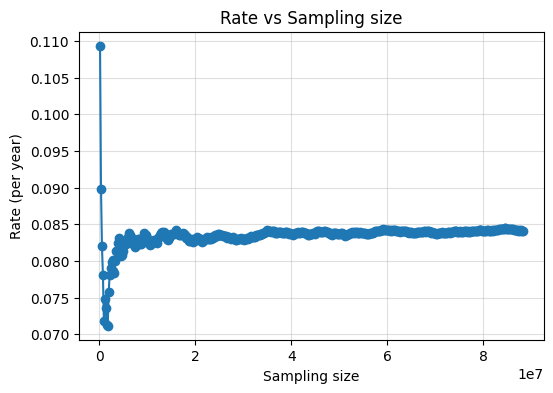

In [100]:
# rate 
meta_data= get_param_from_json("ler_data/meta_lensed_gw.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [101]:
lensed_param_detectable = get_param_from_json("ler_data/n_lensed_params_detectable_gw.json")
# select only events after sampling size of
idx = np.where(meta_data['events_total'] > 1.5e7)[0]
# take average
rate_lensed_sub = np.mean(meta_data['total_rate'][idx])
print('Lensed GW Rate (per year, sub-threshold considered) =', rate_lensed_sub)

# check how many of the events are super-threshold
snr_lensed = lensed_param_detectable['optimal_snr_net']
# only super-threshold events
num_ =  np.sum(np.sum(snr_lensed>8, axis=1)>=2)

rate_lensed_super = rate_lensed_sub*num_/len(snr_lensed)
print('Lensed GW Rate (per year, super-threshold considered) =', rate_lensed_super)

Lensed GW Rate (per year, sub-threshold considered) = 0.0837716825487087
Lensed GW Rate (per year, super-threshold considered) = 0.029650023699053278


In [102]:
# save the data for new_lensed_param_detectable
new_lensed_param_detectable = lensed_param_detectable.copy()

# select only super-threshold events
idx = np.where(np.sum(snr_lensed>8, axis=1)>=2)[0]
for key in new_lensed_param_detectable.keys():
    new_lensed_param_detectable[key] = new_lensed_param_detectable[key][idx]

# save the data
from ler.utils import append_json

lensed_param_detectable = append_json("ler_data/n_lensed_params_detectable_gw_super.json", new_lensed_param_detectable, replace=True)

### How many detectable events are there in terms of GRB pdet out of already detected events in terms of GW snr?

In [103]:
# get snr for the lensed events
pdet_lensed,_ = ler.get_lensed_snrs(
    lensed_param=lensed_param_detectable,
    list_of_detectors=['L1','H1','V1'],
    pdet_calculator=pdet_calculator,
)

# only detectable GRBs
num_ =  np.sum(np.sum(pdet_lensed['pdet_net']==1, axis=1)>=2)

In [105]:
# number of detectable events in terms of GRB pdet out of already detected events in term of GW snr
print(f"Number of lensed detectable events in terms of GRB pdet is {num_} \nout of {len(pdet_lensed['pdet_net'])} events that are already detected in terms of GW snr\n")

print(f"if the rate of detectable lensed GWs is {0.029650023699053278}, \nthen the rate of detectable GRBs is {0.029650023699053278*num_/len(pdet_lensed['pdet_net'])}\n")

print(f"ratio (lensed detectable GWs)/(lensed detectable GRBs) = {len(pdet_lensed['pdet_net'])/num_}")



Number of lensed detectable events in terms of GRB pdet is 62 
out of 3361 events that are already detected in terms of GW snr

if the rate of detectable lensed GWs is 0.029650023699053278, 
then the rate of detectable GRBs is 0.0005469507495808697

ratio (lensed detectable GWs)/(lensed detectable GRBs) = 54.20967741935484


## Final results

### Table for GRB and GW rates

| Event | Unlensed | Lensed | ratio(Unlensed/Lensed) |
| --- | --- | --- | --- |
| GW | 13.18 | 2.96e-2 | 1:454.48 |
| GRB | 0.632 | 4.56e-4 | 1:1404.4 |
| ratio(GRB/GW) | 1:20 | 1:64 | - |


Important takeaways:

Unlensed (detectable): out of 20 GW BNS events, we can expect 1 GRB counter part.

Lensed (detectable): out of 65 GW BNS events, we can expect 1 GRB counter part.